### 为什么需要RNN
RNN是一种拥有记忆的网络, 一旦网络接收到了输入, 就会改变它的隐藏变量. 这个隐藏变量会参与RNN的前向运算, 从而让之前的输入x, 能影响现在的输出o. 具有这种性质的它通常用于处理序列信息. 序列信息比起之前的传统模式分类有着一些不太好的性质, 语音和文本信号, 都是变长的. 而且文本信息常常是每个词对应一个one-hot编码或者一个word-embedding词向量, 而语音信号的采样率又非常高, 一段简单的声音有可能对应着几千长度的序列. 变长的数据还比较容易处理, 毕竟我们在数据科学中也会遇到缺失值, 直接补0即可. 但是考虑到数据可能很长也可能很短, 我们想把它们一同处理就必须把所有数据对齐最长的那个.这样就造成了不必要的算力浪费. 最长的数据的维度可能很高(几k甚至几百k), 也就是至少我们输入层的input_size就很大, 即至少输入层的参数会非常非常多. 如果设计一个巨型的网络来处理序列数据显然是浪费的.  
我们需要更好的架构来处理序列数据, 这时RNN就很有用了. RNN可以自由处理变长序列, 但是每次运算的输入只有一个词向量那么大. 这样就大大节约了参数. 同时也减少了计算.  
### 结构与前向传播
![rnn_arch.PNG](rnn_arch.PNG)
RNN的计算和前馈网络相似, 每次RNN前向传播会同时接收两个向量, 一个是我们当前时刻的输入x, 另一个是保存在存储单元中的向量h. 我们会同时用这两个向量, 经过两个线性层, 得到RNN的隐层输出. 这个隐层输出会成为新的存储单元中的向量h, 参与下一次运算. 而当前时刻我们还会把这个h经过输出线性层, 再经过一个激活函数(softmax)得到当前时刻的输出.这个过程如果进行计算图展开就可以写成
![rnn_unfold.png](rnn_unfold.png)
我们的参数一共有三个线性层, 三个权重矩阵和三个偏置. 我们在实践时一般会把W和U对应的偏置合二为一, 也就是这样的RNN架构需要5种参数.  
从0时刻开始, 我们的h一开始会被初始化为0. 然后, 我们用两个线性层和一个激活函数计算新的h.
$$ h_1 = \sigma(x_1U+h_0W+b) $$
当前时刻的输出就由h1继续运算得到
$$ o_1 = h_1V+c $$
然后, 我们会接受新的x输入, 它和新的h一共继续这样运算下去
$$ h_t = \sigma(x_tU+h_{t-1}W+b) $$
$$ o_t = h_tV+c $$
这就是最简单的RNN架构, 如果让它接收完一整个序列信息, 他就可以输出一个和整个序列都有相关性的输出, 然后根据我们想要什么, 就可以设置合适的损失函数, 并用梯度方法训练它. 
### 反向传播(BPTT)
RNN的参数梯度该如何计算呢? 如果你使用Pytorch的计算图模型来计算梯度, 就会发现这其实并不需要任何其他的backward_fn的设计, 因为我们只是用了一些激活函数和线性层, 我们之前的推导已经完全够用. 唯一需要注意的点是, 我们在计算图中进行了权值共享, 把同一个V,W,U使用了好多遍, 这时要计算导数时, 就需要把每个V,W,U的导数都计算一次, 然后把它们加起来.  
![rnn_bp.PNG](rnn_bp.PNG)
这里我们先计算出图中每个部分导, 然后再给出参数的导数到底该怎么计算的公式.  
首先t时刻的输出损失$L_t$和t时刻的h是有直接相关性的, 因为$o_t = h_tV+c$, 我们这里可以直接计算V和c的偏导, 并计算出h关于$L_t$的偏导. 注意这并不是h的全部偏导, 我们还要考虑来自t+x时间的损失$L_{t+x}$的导数.设序列的总长度为K.
$$ \frac{\partial L_t}{\partial V} = h_t^T\frac{\partial L_t}{\partial o_t} $$
$$ \frac{\partial L_t}{\partial c} = SUMROW\ \frac{\partial L_t}{\partial o_t} $$
$$ \frac{\partial L_t}{\partial h_t} = \frac{\partial L_t}{\partial o_t}V^T $$
$$ \frac{\partial L}{\partial V} = \sum_{k=1}^K h_k^T\frac{\partial L_k}{\partial y_k} $$
$$ \frac{\partial L}{\partial c} = \sum_{k=1}^K SUMROW\ \frac{\partial L_k}{\partial y_k} $$
从上图我们知道, 任意$h_t$关于损失的导数要同时考虑$L_t$到$L_k$所有这些的损失. 对一个$L_k, k>t$, 我们要计算它对$h_t$的导数如下
$$ \frac{\partial L_k}{\partial h_t} = \frac{\partial L_k}{\partial h_k}\prod_{i=t}^{k-1}\frac{\partial h_{i+1}}{\partial h_{i}} $$
$$ \frac{\partial h_{i+1}}{\partial h_{i}} = \sigma'W^T $$
如果我们使用tanh激活函数, 设$v_{t+1} = x_{t+1}U+h_tW+b$, $h_{t+1} = tanh(v_{t+1})$, 则能写出$\frac{\partial h_{i+1}}{\partial h_{i}}$更精确的形式.
$$ \frac{\partial h_{i+1}}{\partial h_{i}} = (1-h_{i+1}^2)\cdot W^T $$
这样我们就能给出任意$h_t$关于总损失L的导数完整的形式
$$ \frac{\partial L}{\partial h_t} = \sum_{k = t}^K\frac{\partial L_k}{\partial h_t} = \sum_{k = t}^K\frac{\partial L_k}{\partial h_k}\prod_{i=t}^{k-1}(1-h_{i+1}^2)\cdot W^T $$
然后任务就是根据$\frac{\partial L}{\partial h_{t}}$计算W,U和b的导数. 虽然W,U,b是权值共享, 我们还是把不同时刻的它们写成$W_t,U_t,b_t$方便描述
$$ \frac{\partial L}{\partial W_t} = h_{t-1}^T\sigma'\frac{\partial L}{\partial h_{t}} = h_{t-1}^T ((1-h_{t}^2)\cdot \frac{\partial L}{\partial h_{t}}) $$
$$ \frac{\partial L}{\partial U_t} = x_{t}^T\sigma'\frac{\partial L}{\partial h_{t}} = x_{t}^T ((1-h_{t}^2)\cdot \frac{\partial L}{\partial h_{t}}) $$
$$ \frac{\partial L}{\partial b_t} = SUMROW\ \sigma'\frac{\partial L}{\partial h_{t}} = SUMROW\ ((1-h_{t}^2)\cdot \frac{\partial L}{\partial h_{t}}) $$
权值共享的参数, 最后更新时要把这些不同时刻t得到的导数加起来, 才是最终的损失函数关于参数的导数
$$ \frac{\partial L}{\partial W} = \sum_{k=1}^K \frac{\partial L}{\partial W_k} $$
$$ \frac{\partial L}{\partial U} = \sum_{k=1}^K \frac{\partial L}{\partial U_k} $$
$$ \frac{\partial L}{\partial b} = \sum_{k=1}^K \frac{\partial L}{\partial b_k} $$
### 训练技巧
很显然, RNN无法像CNN一样, 实现超高度的并行化. CNN中, 我们可以在图像与图像间并行计算, 也能在卷积核与卷积核间并行计算. 但是RNN不行, RNN任意时刻的输入都取决于前面时刻的运算, 直到t-1时刻的运算完成, t时刻的运算才能开始. 这就使得RNN的运算很缓慢, 尽管如此, 我们还是希望尽可能并行化计算. 之前使用的mini-batch实际上仍然能在RNN中使用. 虽然一个batch中的数据有长有短, 我们只需要按照batch中最长的那个把所有数据在时间上对齐, 不足的补零. 这样时刻t就能一次输入n个m维的向量x, 即输入是n行m列矩阵$\{x_{1t};x_{2t}...,x_{nt}\}$.   
另外RNN的训练有一些很不好的性质, 我们看$\frac{\partial L}{\partial h_{t}}$的公式, 它是把很多的$\frac{\partial h_{t+1}}{\partial h_{t}}=\frac{1}{1-v_{i+1}^2}\cdot W^T$做连乘, 而因为$W$权值共享, 每次的$\frac{\partial h_{t+1}}{\partial h_{t}}$相差并不会很大. 设想, 如果所有$\frac{\partial h_{t+1}}{\partial h_{t}}\simeq 1.01$, 序列长度为1000, 对$\frac{\partial L}{\partial h_{1}}$计算导数将会有1.01^{100} = 20959那么大, 这就是RNN的短板, 梯度爆炸. 在优化的目标函数中会非常常见这样的"悬崖", 如果我们用这个梯度更新参数, 将会让参数直接废掉. 为此我们会用一些简单的处理方式来缓解这种影响, 比如每隔T个时间单位就清零前面传来的梯度, 或是更新参数时设计clip截断梯度.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
path = os.getcwd()
os.chdir('..')
from deepnotes import *
os.chdir(path)
from sklearn.metrics import accuracy_score
# 用于验算梯度
import torch
import torch.nn as nn
import torch.nn.functional as F

不含输出层，仅含输入层和隐层两个线性层的RNN只需要不断计算下面的式子即可
$$ h_t = \sigma(x_tU+h_{t-1}W+b) $$

In [2]:
weight_ih = torch.randn(3,2)
weight_hh = torch.randn(2,2)
bias = torch.zeros(2)

weight_ih.requires_grad_(True)
weight_hh.requires_grad_(True)
bias.requires_grad_(True)

seq_len = 4

h = torch.zeros((4,2))
x = torch.randn(4,seq_len,3)
y = torch.randn(4,2)

for t in range(seq_len):
    v = x[:,t,:].mm(weight_ih)+h.mm(weight_hh)+bias
    h = torch.tanh(v)

print(h)
    
loss = F.mse_loss(h,y,reduction='sum')
loss.backward()

print('dw_ih:\n',weight_ih.grad)
print('dw_hh:\n',weight_hh.grad)
print('db:\n',bias.grad)

tensor([[ 0.9418, -0.5154],
        [-0.9824,  0.9829],
        [-0.5701,  0.9826],
        [ 0.7563,  0.6120]], grad_fn=<TanhBackward>)
dw_ih:
 tensor([[-0.0239, -1.8457],
        [-1.4684,  1.5550],
        [ 2.3151,  1.2533]])
dw_hh:
 tensor([[-1.1513, -1.1194],
        [ 0.6028,  2.6666]])
db:
 tensor([ 4.4169, -0.6943])


In [3]:
x = x.numpy()
y = y.numpy()

rnn = RNN(3,2)
rnn.weight_ih = weight_ih.detach().numpy()
rnn.weight_hh = weight_hh.detach().numpy()
rnn.bias = bias.detach().numpy()

h = rnn(x)
rnn.backward(2*(h-y))

print(h)

print('dw_ih:\n',rnn._dw_ih)
print('dw_hh:\n',rnn._dw_hh)
print('db:\n',rnn._db)

[[ 0.94184225 -0.51541592]
 [-0.98241899  0.98293309]
 [-0.57011113  0.98261379]
 [ 0.7562784   0.61203227]]
dw_ih:
 [[-0.02388615 -1.84567514]
 [-1.46839742  1.55497676]
 [ 2.3151302   1.25326869]]
dw_hh:
 [[-1.1513377  -1.11943905]
 [ 0.60276456  2.66664582]]
db:
 [ 4.41694133 -0.69426939]


### 姓名国别分类
不同国家的姓名的字母组成有着独特的特色，使用RNN可以高效地识别这种组合特征，并完成分类任务。

In [4]:
from io import open
import glob
import unicodedata
import string


def findFiles(path):
    return glob.glob(path)

# 只保留小写字母
all_letters = string.ascii_lowercase
n_letters = len(all_letters)


# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    lines = [''.join(list(filter(str.isalpha, line))).lower() for line in lines]
    return lines

for filename in findFiles('names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    category = category.split('\\')[1]
    # 18种类别
    all_categories.append(category)
    lines = readLines(filename)
    # category_lines：字典类型（类别: 名字list）
    category_lines[category] = lines

n_categories = len(all_categories)

print("all_letters: "+str(len(all_letters)))
print("n_categories: "+str(n_categories))
print("category_lines:"+str(category_lines['Italian'][:5]))

all_letters: 26
n_categories: 18
category_lines:['abandonato', 'abatangelo', 'abatantuono', 'abate', 'abategiovanni']


In [5]:
# 使用one hot encoding
# Find letter index from all_letters, e.g. "a" = 0
# 字母所在位置
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToMatrix(line, seq_len):
    oh_mat = np.zeros((seq_len, n_letters))
    indices = [all_letters.find(letter) for letter in line]
    indices += [0]*(seq_len-len(indices))
    oh_mat[range(seq_len),indices] = 1
    return oh_mat

print(lineToMatrix('Jones',5))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0.]]


In [6]:
# 随机采样训练样本对
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(n_samples):
    x_samples = []
    y_samples = []
    
    for _ in range(n_samples):
        category = randomChoice(all_categories)
        line = randomChoice(category_lines[category])
        x_samples.append(line)
        y_samples.append(all_categories.index(category))
    
    seq_len = max(len(l) for l in x_samples)
    
    line_mat = [lineToMatrix(l,seq_len) for l in x_samples]
    line_mat = np.stack(line_mat)
    return line_mat,np.array(y_samples),line,category

Step [1000/100000], Loss: 3.3742
gagnon / English ✗ (French)
Step [2000/100000], Loss: 2.8794
peck / Greek ✗ (English)
Step [3000/100000], Loss: 2.6554
walker / Scottish ✓
Step [4000/100000], Loss: 2.4007
pan / Chinese ✗ (French)
Step [5000/100000], Loss: 2.2640
safar / Arabic ✓
Step [6000/100000], Loss: 2.1901
hynna / Vietnamese ✗ (Czech)
Step [7000/100000], Loss: 2.1383
vespa / Spanish ✗ (Italian)
Step [8000/100000], Loss: 1.9957
richards / French ✗ (English)
Step [9000/100000], Loss: 1.8898
yoshizawa / Japanese ✓
Step [10000/100000], Loss: 1.7830
rome / Spanish ✗ (French)
Step [11000/100000], Loss: 1.7851
rigatos / Greek ✓
Step [12000/100000], Loss: 1.6827
kalinochkin / Greek ✗ (Russian)
Step [13000/100000], Loss: 1.6173
atterton / Dutch ✗ (English)
Step [14000/100000], Loss: 1.6051
buggenum / Dutch ✓
Step [15000/100000], Loss: 1.6087
reinder / Dutch ✓
Step [16000/100000], Loss: 1.4786
nasato / Arabic ✗ (Italian)
Step [17000/100000], Loss: 1.5427
eltis / English ✓
Step [18000/100000

Text(0.5,1,'Train loss(Cross Entropy)')

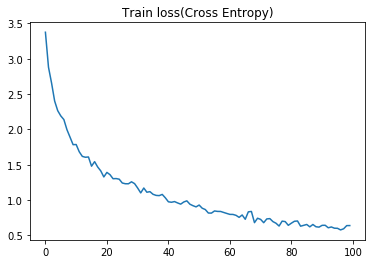

In [7]:
model = Sequential(
    RNN(n_letters,180,requires_clip=True),
    Linear(180,n_categories),
)
loss_func = CrossEntropyLossWithSoftMax(n_categories)
optimizer = SGD(0.001)
model.apply_optim(optimizer)
loss_list = []
running_loss = 0.
num_iters = 100000
log_step = 1000

for i in range(num_iters):
    x,y,name,category = randomTrainingExample(1)
    # Forward pass
    logits = model(x)
    # calculate loss
    loss,dlogits = loss_func(logits,y)
    # Backward
    model.zero_grad()
    model.backward(dlogits)
    # optimize
    optimizer.step()
    
    running_loss += loss.item()

    if (i+1) % log_step == 0:
        running_loss /= log_step
        print ('Step [{}/{}], Loss: {:.4f}'.format(i+1, num_iters, running_loss))
        loss_list.append(running_loss)
        guess = all_categories[np.argmax(logits,axis = 1)[0]]
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%s / %s %s'%(name,guess,correct))
        running_loss = 0.

plt.plot(loss_list)
plt.title('Train loss(Cross Entropy)')

In [8]:
names = ['hinton','lecun','goodfellow','ming','satoshi']

for name in names:
    mat = lineToMatrix(name,len(name))
    x = mat[np.newaxis,:]
    y_pred = model(x)[0]
    indices = np.argsort(-y_pred)[:3]
    print('>'+name)
    for i,idx in enumerate(indices):
        print('top %d:'%(i+1),all_categories[idx],'(%.4f)'%(y_pred[idx]))

>hinton
top 1: English (5.2533)
top 2: Scottish (3.9399)
top 3: German (2.8684)
>lecun
top 1: English (4.7236)
top 2: French (4.5072)
top 3: German (4.2887)
>goodfellow
top 1: Russian (4.4157)
top 2: English (4.0306)
top 3: Greek (3.5681)
>ming
top 1: Chinese (7.2009)
top 2: Korean (4.6924)
top 3: Vietnamese (4.4949)
>satoshi
top 1: Italian (4.8519)
top 2: Polish (4.0977)
top 3: Japanese (4.0213)


### LSTM
![lstm.jpg](lstm.jpg)